<img src="https://www.cqf.com/themes/custom/creode/logo.svg"
style="vertical-align: top; padding-top: 23px;;width:10.0%"
data-align="left" /> <img
src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg"
style="vertical-align: middle;;width:12.0%" data-align="right" />

Python Labs

GARCH

**Kannan Singaravelu**

kannan.singaravelu@fitchlearning.com

## Volatility<a href="#Volatility" class="anchor-link">¶</a>

Asset price volatility is central to derivatives pricing. It is defined
as measure of price variability over certain period of time. In essence,
it describes standard deviation of returns. There are different types of
volatility: Historical, Implied, Forward. In most cases, we assume
volatility to be constant, which is clearly not true and numerous
studies have been dedicated to estimate this variable, both in academia
and industry.

Volatility estimation by statistical means assume equal weights to all
returns measured over the period. We know that over 1-day, the mean
return is small as compared to standard deviation. If we consider a
simple *m*-period moving average, where \$\sigma_n\$ is the volatility
of return on day n, then with \$\overline u\$ \$\approx\$ 0, we have  
  

\$\$ \sigma^2_n = \frac 1 m \sum\_{i=1}^m u^2\_{n-i} \$\$

where, \$u\$ is return and \$\sigma^2\$ is the variance.

However, any large return within this *n* period will elevate the
volatility until it drops out of the sample. Further, we observe
volatility is mean reverting and tends to vary about a long term mean.
To address this effect, we adopt to the weighting schemes.  
  

\$\$ \sigma^2_n = \omega + \sum\_{i=1}^m \alpha_i u^2\_{n-i} \$\$

where, \$\omega = \gamma \overline \sigma^2\$ and weights must sum to 1.

This is known as **Autoregressive Conditional Heteroscedastic** model.

## ARCH<a href="#ARCH" class="anchor-link">¶</a>

**Autoregressive** models are a statistical technique involving a
regression of lagged values where the model suggests that past values
can help forecast future values of the same variable. Within the model,
a time series is the dependent variable and lagged values are the
independent variables.

The ARCH model, was originally developed by Robert Engle in 1982 to
measure the dynamics of inflation uncertainty. **Conditional
heteroskedasticity** refers to the notion that the next period’s
volatility is conditional on the volatility in the current period as
well as to the time varying nature of volatility. However, given the
volatility dynamics, this model fail to fully capture the persistence of
volatility.

## GARCH<a href="#GARCH" class="anchor-link">¶</a>

To address the shortcoming, ARCH has been extended to a generalised
framework where we add volatility as a forecasting feature by adding
previous variance. This method is popularly known as **Generalized
ARCH** or **GARCH** model.  
  

\$\$ \sigma^2_n = \omega + \sum\_{i=1}^p \alpha_i u^2\_{n-i} +
\sum\_{i=1}^q \beta_i \sigma^2\_{n-i} \$\$

where, \$p\$ and \$q\$ are lag length.

**GARCH(1,1)** is then represented as,

\$\$ \sigma^2_n = \omega + \alpha u^2\_{n-i} + \beta \sigma^2\_{n-i}
\$\$

  

where, \$\alpha + \beta \< 1\$ and \$\gamma + \alpha + \beta = 1\$ as
weight applied to long term variance cannot be negative.

The GARCH model is a way of specifying the dependence of the time
varying nature of volatility. The model incorporates changes in the
fluctuations in volatility and tracks the persistence of volatility as
it fluctuates around its long-term average and are exponentially
weighted.

To model GARCH or the conditional volatility, we need to derive
\$\omega\$, \$\alpha\$, \$\beta\$ by maximizing the likelihood function.

### Import Libraries<a href="#Import-Libraries" class="anchor-link">¶</a>

In \[1\]:

    import pandas as pd
    import numpy as np

    from scipy.stats import norm
    from scipy.optimize import minimize

    import matplotlib.pyplot as plt
    from matplotlib.pyplot import rcParams
    rcParams['figure.figsize'] = 16, 8

    import warnings
    warnings.filterwarnings('ignore')

### Retrieve Data<a href="#Retrieve-Data" class="anchor-link">¶</a>

We will use the FAANG stocks as before to build for calculation of VaR

In \[2\]:

    # Load locally stored data
    df = pd.read_csv('data/vol.csv', parse_dates=True, index_col=0, dayfirst=True)

    # Check first 5 values 
    df.head()

Out\[2\]:

|            | VIX   | S&P 500 |
|------------|-------|---------|
| DATE       |       |         |
| 1990-01-02 | 18.19 | 386.162 |
| 1990-01-03 | 18.19 | 385.171 |
| 1990-01-04 | 19.22 | 382.018 |
| 1990-01-05 | 20.11 | 378.299 |
| 1990-01-08 | 20.26 | 380.039 |

In \[3\]:

    # Visualize FTSE 100 Index Price
    plt.plot(df['S&P 500'], color='orange')
    plt.title('S&P 500 Index')
    plt.grid(True)

![](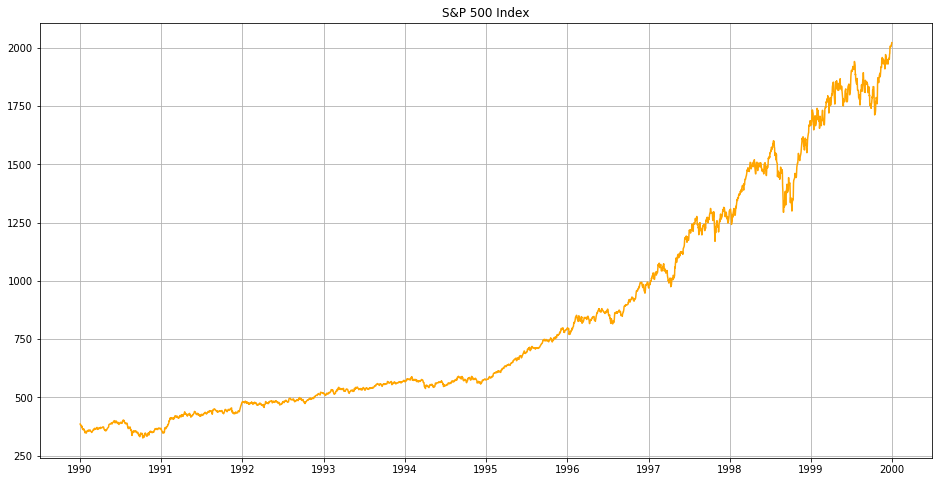%0A)

### Calculate Log Returns<a href="#Calculate-Log-Returns" class="anchor-link">¶</a>

In \[4\]:

    # Calculate daily returns
    returns = np.log(df['S&P 500']).diff().fillna(0)

In \[5\]:

    returns

Out\[5\]:

    DATE
    1990-01-02    0.000000
    1990-01-03   -0.002570
    1990-01-04   -0.008220
    1990-01-05   -0.009783
    1990-01-08    0.004589
                    ...   
    1999-12-27   -0.000851
    1999-12-28    0.000386
    1999-12-29    0.004103
    1999-12-30    0.000707
    1999-12-31    0.003267
    Name: S&P 500, Length: 2528, dtype: float64

In \[6\]:

    # Visualize FTSE 100 Index daily returns
    plt.plot(returns, color='orange')
    plt.title('S&P 500 Index Returns')
    plt.grid(True)

![](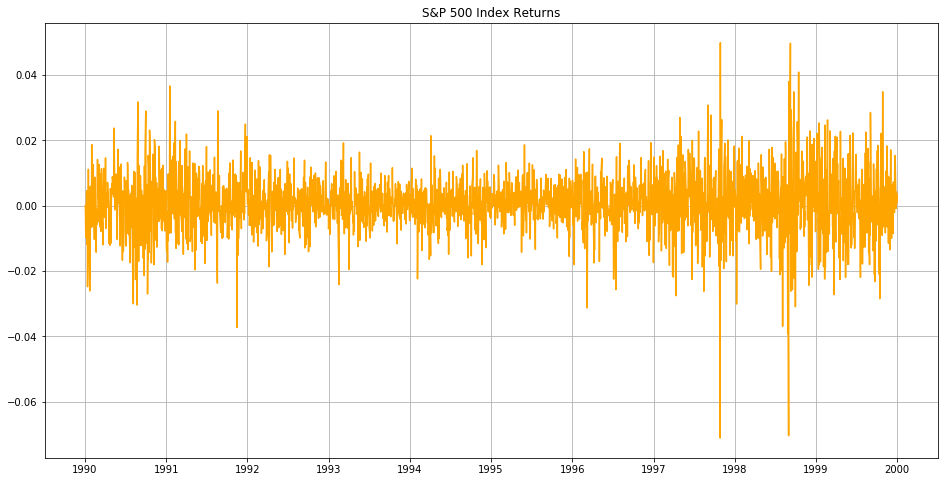%0A)

## Numerical Optimization<a href="#Numerical-Optimization" class="anchor-link">¶</a>

We will use Numerical optimization to maximize the likelihood
estimation. Numerical optimization is typically implemented to find the
minimum of a function rather than the maximum and the function to be
minimize is called an objective function. For maximum likelihood
estimation, we simply define a negative log likelihood as our objective
function.

### GARCH<a href="#GARCH" class="anchor-link">¶</a>

Advantage of using a GARCH method when compared to EWMA is the inclusion
of long term variance or volatility as a forecasting feature.

In \[7\]:

    # GARCH(1,1) function
    def garch(omega, alpha, beta, ret):
        
        length = len(ret)
        
        var = []
        for i in range(length):
            if i==0:
                var.append(omega/np.abs(1-alpha-beta))
            else:
                var.append(omega + alpha * ret[i-1]**2 + beta * var[i-1])
                
        return np.array(var)

In \[8\]:

    garch(0.00000790570,0.1,0.8,returns)[:3]

Out\[8\]:

    array([7.90570000e-05, 7.11513000e-05, 6.54870136e-05])

### Maximum Likelihood Estimation<a href="#Maximum-Likelihood-Estimation" class="anchor-link">¶</a>

Maximum Likeihood Estimation (MLE) is a statistical method used for
fitting the data to a model. When using MLE, we first assume a
distribution (ie., a parametric model) and then try to determine the
model parameters. To estimate GARCH(1,1) parameters, we assume
distribution of returns conditional on variance are normally
distributed.

We maximize,

\$\$ \sum\_{i=1}^n log \Bigg\[ \frac1{\sqrt{2\pi\sigma_i^2}} \\
e^\frac{-(u_i-\overline u)^2}{2\sigma_i^2} \Bigg\] \$\$

to derive \$\omega\$, \$\alpha\$ and \$\beta\$.

In \[9\]:

    # Log likelihood function
    def likelihood(params, ret):
        
        length = len(ret)
        omega = params[0]
        alpha = params[1]
        beta = params[2]
        
        variance = garch(omega, alpha, beta, ret)
        
        llh = []
        for i in range(length):
            llh.append(np.log(norm.pdf(ret[i], 0, np.sqrt(variance[i]))))
        
        return -np.sum(np.array(llh))

In \[10\]:

    likelihood((0.00000790570, 0.1, 0.8),returns)

Out\[10\]:

    -8540.382225783567

### Optimization<a href="#Optimization" class="anchor-link">¶</a>

Next, to optimize the GARCH parameters, we will use the *`minimize`*
function from `scipy` optimization module. The objective function here
is a function returning maximum log likelihood and the target variables
are GARCH parameters.

Further, we use the `Nelder–Mead` method also known as downhill simplex
method which is a commonly applied to numerical method to find the
minimum or maximum of an objective function in a multidimensional space.
The simplex algorithm is probably the simplest way to minimize a fairly
well-behaved function. It requires only function evaluations and is a
good choice for simple minimization problems. The downside to this
method is it may take longer to find the minimum as it does not use any
gradient evaluations.

In \[11\]:

    # Specify optimization input
    param = ['omega', 'alpha', 'beta']
    initial_values = (0.00000790570, 0.1,0.8)

In \[12\]:

    res = minimize(likelihood, initial_values, args = returns, 
                       method='Nelder-Mead', options={'disp':False})

In \[13\]:

    res

Out\[13\]:

     final_simplex: (array([[4.65438215e-07, 4.88435228e-02, 9.46474229e-01],
           [4.65063741e-07, 4.87639127e-02, 9.46541931e-01],
           [4.66370864e-07, 4.88380272e-02, 9.46468659e-01],
           [4.67308946e-07, 4.89011789e-02, 9.46392665e-01]]), array([-8596.64590336, -8596.64589904, -8596.64589338, -8596.64585848]))
               fun: -8596.64590335503
           message: 'Optimization terminated successfully.'
              nfev: 135
               nit: 77
            status: 0
           success: True
                 x: array([4.65438215e-07, 4.88435228e-02, 9.46474229e-01])

In \[14\]:

    res['x']

Out\[14\]:

    array([4.65438215e-07, 4.88435228e-02, 9.46474229e-01])

In \[15\]:

    # GARCH parameters
    dict(zip(param,np.around(res['x']*100,4)))

Out\[15\]:

    {'omega': 0.0, 'alpha': 4.8844, 'beta': 94.6474}

In \[16\]:

    # Parameters
    omega = res['x'][0] 
    alpha = res['x'][1]
    beta = res['x'][2]

    # Variance
    var = garch(res['x'][0],res['x'][1],res['x'][2],returns)

    # Annualised conditional volatility
    ann_vol = np.sqrt(var*252) * 100
    ann_vol

Out\[16\]:

    array([15.82720004, 15.43583318, 15.08301156, ..., 14.05045667,
           13.78742288, 13.45929364])

### Visualize Volatility<a href="#Visualize-Volatility" class="anchor-link">¶</a>

In \[17\]:

    # Visualise GARCH volatility and VIX
    plt.title('Annualized Volatility')
    plt.plot(returns.index, ann_vol, color='orange', label='GARCH')
    plt.plot(returns.index, df['VIX'], color='blue', label = 'VIX')
    plt.legend(loc=2)
    plt.grid(True)

![](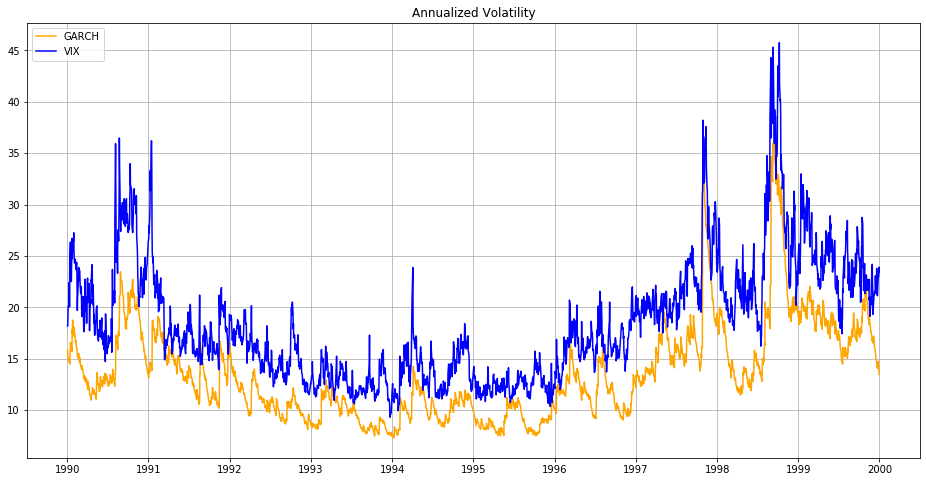%0A)

### N-day Forecast<a href="#N-day-Forecast" class="anchor-link">¶</a>

Extending the GARCH(1,1) model to forecast future volatility, we can
derive the n-days ahead forecast using the following equation.

\$\$ E\[\sigma^2\_{n+k}\] = \overline{\sigma}\space{^2} +
(\alpha+\beta)^k \* (\sigma^2_n - \overline{\sigma}\space{^2}) \$\$

where, \$\overline{\sigma}\space{^2}\$ is the long run variance and
\$\alpha\$ and \$\beta\$ are GARCH parameters.

We know that volatility has the tendency to revert to its long run
range. And, \$\alpha + \beta \< 1\$ in GARCH(1,1) and hence when k gets
larger, the second term gets smaller and the forecast tends towards the
long term variance.

In \[18\]:

    # Calculate N-day forecast
    longrun_variance = omega/(1-alpha-beta)
     
    fvar = []
    for i in range(1,732):    
        fvar.append(longrun_variance + (alpha+beta)**i * (var[-1] - longrun_variance))

    var = np.array(fvar)

In \[19\]:

    # Verify first 10 values
    var[:10]

Out\[19\]:

    array([7.20147969e-05, 7.21430440e-05, 7.22706906e-05, 7.23977395e-05,
           7.25241936e-05, 7.26500556e-05, 7.27753282e-05, 7.29000143e-05,
           7.30241166e-05, 7.31476378e-05])

In \[20\]:

    # Plot volatility forecast over different time horizon
    plt.axhline(y=np.sqrt(longrun_variance*252)*100, color='blue')
    plt.plot(np.sqrt(var*252)*100, color='red')

    plt.xlabel('Horizon (in days)')
    plt.ylabel('Volatility (%)')

    plt.annotate('GARCH Forecast', xy=(650,15.60), color='red')
    plt.annotate('Longrun Volatility =' + str(np.around(np.sqrt(longrun_variance*252)*100,2)) + '%', 
                 xy=(0,15.70), color='blue')

    plt.title('Volatility Forecast : N-days Ahead')
    plt.grid(axis='x')

![](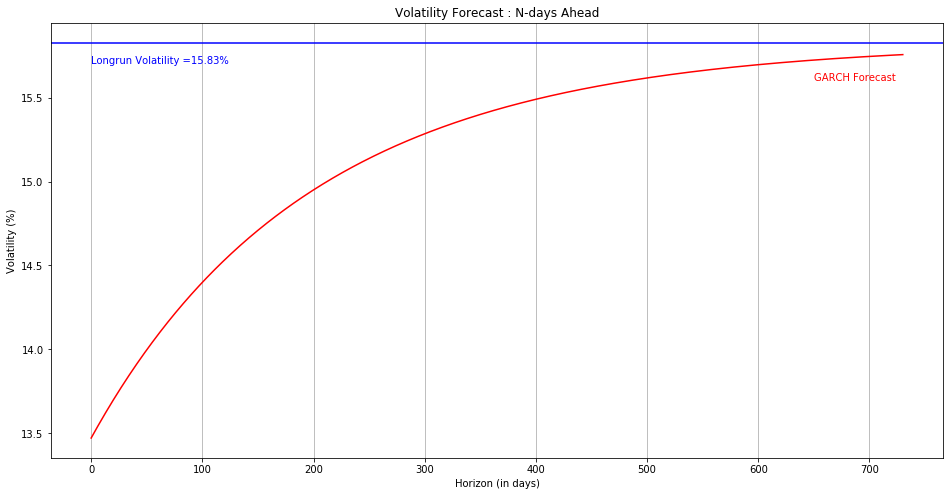%0A)

## ARCH Toolbox<a href="#ARCH-Toolbox" class="anchor-link">¶</a>

ARCH is one of the popular tools used for financial econometrics,
written in Python - with Cython and/or Numba used to improve
performance. We will now use `arch_model` to fit our GARCH model using
this package.

In \[21\]:

    # Import arch library
    from arch import arch_model

In \[22\]:

    # Mean zero
    g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='Normal')

In \[23\]:

    model = g1.fit()

    Iteration:      1,   Func. Count:      5,   Neg. LLF: -8585.448810648937
    Iteration:      2,   Func. Count:     14,   Neg. LLF: -8586.069358190143
    Iteration:      3,   Func. Count:     20,   Neg. LLF: -8588.393939229207
    Optimization terminated successfully.    (Exit mode 0)
                Current function value: -8588.393940307446
                Iterations: 7
                Function evaluations: 20
                Gradient evaluations: 3

In \[24\]:

    # Model output
    print(model)

                           Zero Mean - GARCH Model Results                        
    ==============================================================================
    Dep. Variable:                S&P 500   R-squared:                       0.000
    Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
    Vol Model:                      GARCH   Log-Likelihood:                8588.39
    Distribution:                  Normal   AIC:                          -17170.8
    Method:            Maximum Likelihood   BIC:                          -17153.3
                                            No. Observations:                 2528
    Date:                Thu, Jul 30 2020   Df Residuals:                     2525
    Time:                        12:13:04   Df Model:                            3
                                  Volatility Model                              
    ============================================================================
                     coef    std err          t      P>|t|      95.0% Conf. Int.
    ----------------------------------------------------------------------------
    omega      1.6961e-06  1.577e-09   1075.827      0.000 [1.693e-06,1.699e-06]
    alpha[1]       0.0901  1.911e-02      4.715  2.414e-06   [5.266e-02,  0.128]
    beta[1]        0.8920  1.575e-02     56.640      0.000     [  0.861,  0.923]
    ============================================================================

    Covariance estimator: robust

In \[25\]:

    # Model params
    model.params

Out\[25\]:

    omega       0.000002
    alpha[1]    0.090115
    beta[1]     0.892040
    Name: params, dtype: float64

In \[26\]:

    # Plot annualised vol
    fig = model.plot(annualize='D')

![](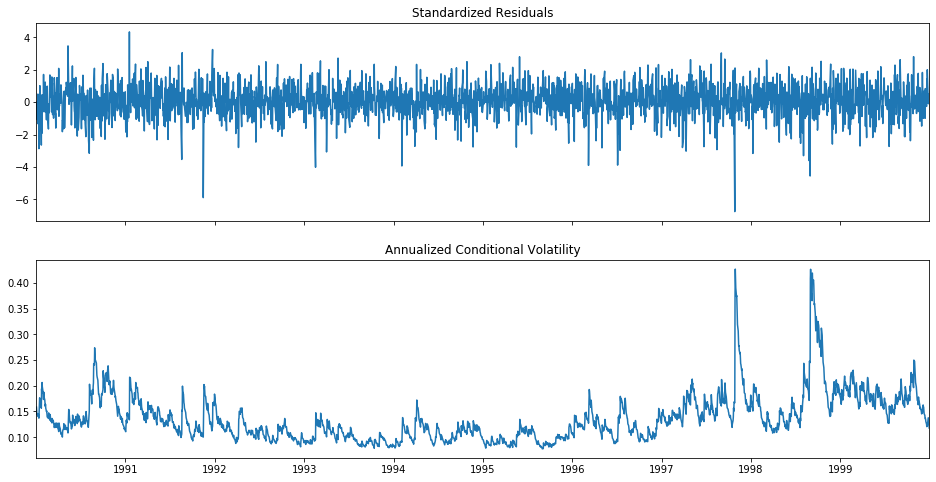%0A)

In \[27\]:

    model.conditional_volatility*np.sqrt(252)

Out\[27\]:

    DATE
    1990-01-02    0.158414
    1990-01-03    0.151040
    1990-01-04    0.144663
    1990-01-05    0.143631
    1990-01-08    0.144926
                    ...   
    1999-12-27    0.137821
    1999-12-28    0.131863
    1999-12-29    0.126259
    1999-12-30    0.122597
    1999-12-31    0.117670
    Name: cond_vol, Length: 2528, dtype: float64

In \[28\]:

    # Constant mean
    g2 = arch_model(returns, vol='GARCH', mean='Constant', p=1, o=0, q=1, dist='Normal')

In \[29\]:

    # Model output
    model2 = g2.fit(disp='off')
    print(model2)

                         Constant Mean - GARCH Model Results                      
    ==============================================================================
    Dep. Variable:                S&P 500   R-squared:                      -0.000
    Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
    Vol Model:                      GARCH   Log-Likelihood:                8598.87
    Distribution:                  Normal   AIC:                          -17189.7
    Method:            Maximum Likelihood   BIC:                          -17166.4
                                            No. Observations:                 2528
    Date:                Thu, Jul 30 2020   Df Residuals:                     2524
    Time:                        12:13:04   Df Model:                            4
                                     Mean Model                                 
    ============================================================================
                     coef    std err          t      P>|t|      95.0% Conf. Int.
    ----------------------------------------------------------------------------
    mu         7.4043e-04  8.991e-06     82.350      0.000 [7.228e-04,7.581e-04]
                                  Volatility Model                              
    ============================================================================
                     coef    std err          t      P>|t|      95.0% Conf. Int.
    ----------------------------------------------------------------------------
    omega      1.5799e-06  4.945e-12  3.195e+05      0.000 [1.580e-06,1.580e-06]
    alpha[1]       0.1000  2.190e-02      4.567  4.957e-06   [5.708e-02,  0.143]
    beta[1]        0.8800  1.871e-02     47.029      0.000     [  0.843,  0.917]
    ============================================================================

    Covariance estimator: robust

In \[30\]:

    # Forecast for next 60 days
    model_forecast = model.forecast(horizon=60)

In \[31\]:

    # Subsume forecast values into a dataframe
    forecast_df = pd.DataFrame(np.sqrt(model_forecast.variance.dropna().T *252)*100)
    forecast_df.columns = ['Cond_Vol']
    forecast_df.head()

Out\[31\]:

|      | Cond_Vol  |
|------|-----------|
| h.01 | 11.411012 |
| h.02 | 11.496164 |
| h.03 | 11.579188 |
| h.04 | 11.660155 |
| h.05 | 11.739133 |

In \[32\]:

    # long run variance from model forecast
    lrv = model.params[0]/(1-model.params[1]-model.params[2])

    # long run variance
    np.sqrt(lrv*252)*100

Out\[32\]:

    15.476530711084429

In \[33\]:

    # Plot volatility forecast over a 60-day horizon
    plt.plot(forecast_df, color='blue')
    plt.xlim(0,60)
    plt.xticks(rotation=90)
    plt.xlabel('Horizon (in days)')
    plt.ylabel('Volatility (%)')
    plt.title('Volatility Forecast : 60-days Ahead');
    plt.grid(True)

![](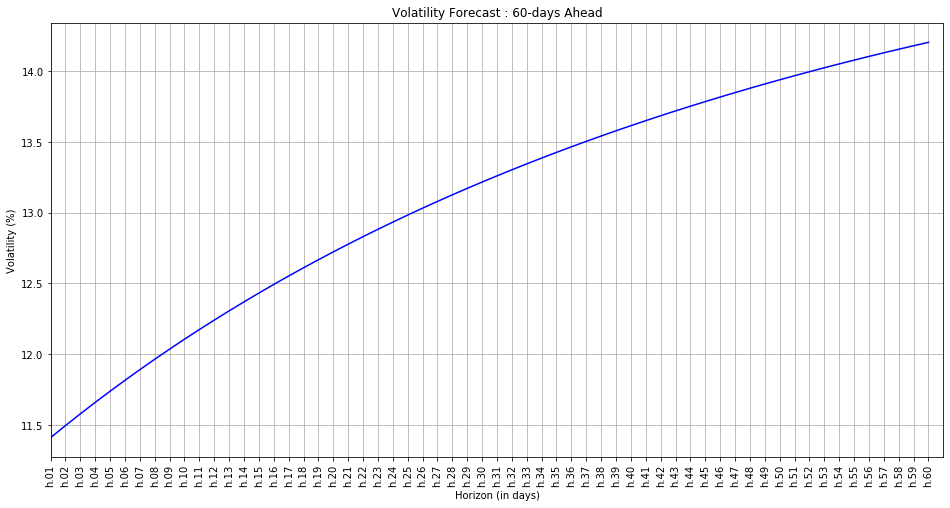%0A)

# References<a href="#References" class="anchor-link">¶</a>

-   Scipy documentation <https://docs.scipy.org/doc/scipy/reference/>

-   Arch documentation
    <https://arch.readthedocs.io/en/latest/index.html>